index start = 3
/cds/data/drpsrcf/cxi/cxilx9320/scratch/hdf5/smalldata/cxilx9320_Run0051.h5, FILE EXISTS, CONTINUE...
/cds/data/drpsrcf/cxi/cxilx9320/scratch/hdf5/smalldata/cxilx9320_Run0052.h5, FILE EXISTS, CONTINUE...
/cds/data/drpsrcf/cxi/cxilx9320/scratch/hdf5/smalldata/cxilx9320_Run0052.h5, FILE EXISTS, CONTINUE...
Ne theory scale = 1.300000
npy data:
[[0.00000000e+00 1.00100100e-02 2.00200200e-02 ... 9.97997998e+00
  9.98998999e+00 1.00000000e+01]
 [4.89938402e+03 4.89902629e+03 4.89793671e+03 ... 9.76544601e+01
  9.74285938e+01 9.72038645e+01]]
(2, 1000)
/cds/data/drpsrcf/cxi/cxilx9320/scratch/hdf5/smalldata/cxilx9320_Run0053.h5, FILE EXISTS, CONTINUE...
SF6 theory scale = 1.000000
Vector q =
[0.85489378 1.05489378 1.25489378 1.45489378 1.65489378 1.85489378
 2.05489378 2.25489378 2.45489378 2.65489378 2.85489378 3.05489378
 3.25489378 3.45489378 3.65489378 3.85489378 4.05489378 4.25489378
 4.45489378 4.65489378 4.85489378 5.05489378 5.25489378 5.45489378
 5.65489378 5.85489378 

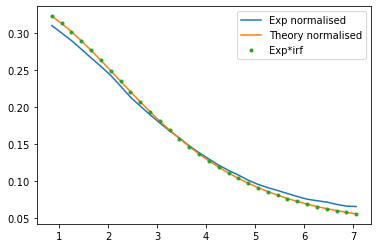

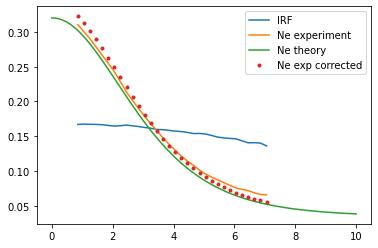

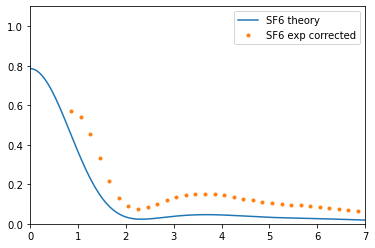

In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

# custom imports (from current directory)
from run_numbers_vars import *  # contains dark, blank, Ne, SF6 run numbers

###
# FUNCTIONS
def is_file(path):
    return os.path.isfile(path)

def runNumToString(num):
    numstr = str(num)
    while len(numstr)<4:
        numstr = '0'+numstr
    return numstr
    
def is_leaf(dataset):
    return isinstance(dataset,h5py.Dataset)

def get_leaves(f,saveto,verbose=False):
    def return_leaf(name):
        if is_leaf(f[name]):
            if verbose:
                print(name,f[name][()].shape)
            saveto[name] = f[name][()]
    f.visit(return_leaf)

def combineRuns(runNumbers,folder,verbose=False):
    data_array = []
    for i,runNumber in enumerate(runNumbers):
        data = {}
        filename = f'{folder}cxilx9320_Run{runNumToString(runNumber)}.h5'
        if is_file(filename):
            print('%s, FILE EXISTS, CONTINUE...' % filename)
        else:
            print('%s, FILE DOES NOT EXIST!' % filename)
        with h5py.File(filename,'r') as f:
            get_leaves(f,data,verbose=verbose)
            data_array.append(data)
    hf1 = h5py.File(filename, 'r')
#    for key in hf1['epicsAll']:
#        print(key)
    data_combined = {}
    for key in keys_to_combine:
        arr = np.squeeze(data_array[0][key])
        for data in data_array[1:]:
            arr = np.concatenate((arr,np.squeeze(data[key])),axis=0)
        data_combined[key] = arr
    run_indicator = np.array([])
    for i,runNumber in enumerate(runNumbers):
        run_indicator = np.concatenate((run_indicator,runNumber*np.ones_like(data_array[i]['tt/FLTPOS'])))
    data_combined['run_indicator'] = run_indicator
    for key in keys_to_sum:
        arr = np.zeros_like(data_array[0][key])
        for data in data_array:
            arr += data[key]
        data_combined[key] = arr
    for key in keys_to_check:
        arr = data_array[0][key]
        for i,data in enumerate(data_array):
            if not np.array_equal(data[key],arr):
                print(f'Problem with key {key} in run {runNumbers[i]}')
        data_combined[key] = arr
    return data_combined
# END FUNCTIONS
###

# KEYS
keys_to_combine = ['tt/FLTPOS',
                   'tt/AMPL',
                   'tt/FLTPOSFWHM',
                   'tt/ttCorr',
                   'tt/FLTPOS_PS',
                   'tt/AMPL',
                   'tt/AMPLNXT',
                   'tt/FLTPOS',
                   'tt/FLTPOS_PS',
                   'tt/REFAMPL',
                   #'scan/lxt_ttc',
                   'ipm_dg2/sum',
                   'ipm_dg3/sum',
                   'gas_detector/f_11_ENRC',
                   #'epicsAll/gasCell_pressure',
                   'jungfrau4M/azav_azav',
                   'evr/code_183',
                   'evr/code_162',
                   'evr/code_141',
                   #'epicsAll/gasCell_pressure',
                   'lightStatus/laser',
                   'lightStatus/xray',
                   # 'scan/var0',
                   #  'scan/LAS:FS5:MMS:PH',
                  ]

keys_to_sum = ['Sums/jungfrau4M_calib',
              'Sums/jungfrau4M_calib_thresADU1']

keys_to_check = ['UserDataCfg/jungfrau4M/azav__azav_q',
                'UserDataCfg/jungfrau4M/azav__azav_qbin',
                'UserDataCfg/jungfrau4M/azav__azav_qbins',
                'UserDataCfg/jungfrau4M/x',
                'UserDataCfg/jungfrau4M/y',
                'UserDataCfg/jungfrau4M/z',
                'UserDataCfg/jungfrau4M/azav__azav_matrix_q',
                'UserDataCfg/jungfrau4M/azav__azav_matrix_phi',
                'UserDataCfg/jungfrau4M/cmask',
                #'UserDataCfg/jungfrau4M/Full_thres__Full_thres_thresADU',
                #'UserDataCfg/jungfrau4M/Full_thres__Full_thres_bound',
                'UserDataCfg/jungfrau4M/common_mode_pars']

# END KEYS
###

# THOMAS FUNCTIONS
def normalise(x, f):
    dx = abs(x[1] - x[0])
    area = dx * np.sum(f)
    f /= area
    return f

def get_azav(runNumbers, indexstart):
    '''
    Returns normalised azimuthal average of Jungfrau for array of 
    run numbers, returns data[indexstart:]
    '''
    data = combineRuns(runNumbers, folder=folder, verbose=False)
    # azimuthal average
    #azav = np.squeeze(data['jungfrau4M/azav_azav'])
    azav  = data['jungfrau4M/azav_azav']
    #print('azav shape: '); print(azav.shape)
    #print(azav.shape)
    azav = np.sum(azav, axis=0)
    
    # q definition
    q = data['UserDataCfg/jungfrau4M/azav__azav_q']
    #qbin  = data['UserDataCfg/jungfrau4M/azav__azav_qbin' ]
    #qbins = data['UserDataCfg/jungfrau4M/azav__azav_qbins']
    return q[indexstart:], azav[indexstart:]

def load_theory(theory_file):
    # Load theory file data
    split_tup = os.path.splitext(theory_file)
    filetype = split_tup[1]
    if filetype == '.txt':
        data = np.loadtxt(theory_file)
    elif filetype == '.npy':
        data = np.load(theory_file)
        data = np.transpose(data)
        print('npy data:'); print(data)
        print(data.shape)
    q_theory = data[0]
    f_theory = data[1]
    return q_theory, f_theory

def interp_theory(q_exp, q_theory, f_theory):
    # interpolate to shape of exp data
    interpolated_values = np.interp(q_exp, q_theory, f_theory)  
    return interpolated_values

def get_irf(run_numbers, blank_subtraction, theory_file, q_exp):
    '''
    Returns the instrument response function (IRF) for calibration run(s)
    '''
    # Get azav for run(s)
    q_not_used, azav = get_azav(run_numbers, indexstart)
    # Subtract blank
    azav_subtracted = azav - blank_subtraction
    # interpolation (make theory curve same shape as experiment q-bins)
    q_theory, f_theory = load_theory(theory_file)
    azav_subtracted = azav_subtracted
    theory_interp = interp_theory(q_exp, q_theory, f_theory)
    #plt.plot(q_theory, ne_theory)
    #plt.plot(q_exp, ne_theory_interp)
    # Normalise before creating IRF
    exp_normalised = normalise(q_exp, azav_subtracted)
    theory_normalised = normalise(q_exp, theory_interp)
    plt.figure()
    plt.plot(q_exp, exp_normalised)
    plt.plot(q_exp, theory_normalised)
    tmp = theory_normalised / exp_normalised
    # convert nan and inf to 0
    irf = np.nan_to_num(tmp, copy=True, posinf=0, neginf=0)
    plt.plot(q_exp, exp_normalised * irf, '.')
    plt.legend(['Exp normalised', 'Theory normalised', 'Exp*irf'])
    return irf

def irf_blank_correction(azav, azav_blank, irf):
    '''
    Applies blank subtraction and IRF correction to an azav curve
    '''
    azav_corrected = (azav - azav_blank) * irf
    return azav_corrected
# END THOMAS FUNCTIONS
###

print('index start = %d' % indexstart)
# BLANK RUN
q, azav_blank = get_azav(blank_run_numbers, indexstart)
# END BLANK RUN
###

# Neon and IRF
tmp, ne_azav = get_azav(ne_run_numbers, indexstart)
q_theory, ne_theory = load_theory(ne_theory_file)
irf = get_irf(ne_run_numbers, azav_blank, ne_theory_file, q)
ne_exp_corrected = irf_blank_correction(ne_azav, azav_blank, irf)
plt.figure()
plt.plot(q, normalise(q, irf))
plt.plot(q, normalise(q, ne_azav))
#scale = np.max(normalise(q, ne_exp_corrected)) / np.max(normalise(q_theory, ne_theory))
scale = 1.3
print('Ne theory scale = %f' % scale)
plt.plot(q_theory, scale*normalise(q_theory, ne_theory)) 
plt.plot(q, normalise(q, ne_exp_corrected), '.')
plt.legend(['IRF', 'Ne experiment', 'Ne theory', 'Ne exp corrected'])

# END Neon and IRF
###

# SF6 sanity check
q_theory, sf6_theory = load_theory(sf6_theory_file)
sf6_theory_normalised = normalise(q_theory, sf6_theory)
tmp, sf6_azav = get_azav(sf6_run_numbers, indexstart)
sf6_azav_corrected = irf_blank_correction(sf6_azav, azav_blank, irf)
sf6_exp_normalised = normalise(q, sf6_azav_corrected)

plt.figure()
#scale = np.max(sf6_exp_normalised) / np.max(sf6_theory_normalised)
scale = 1.0
print('SF6 theory scale = %f' % scale)
A = 1.0
plt.plot(q_theory, A * scale * sf6_theory_normalised)
#print('sf6 azav corrected:')
#print(sf6_azav_corrected)
plt.plot(q, sf6_exp_normalised, '.')
plt.xlim([0, 7])
plt.ylim([0, 1.1])
plt.legend(['SF6 theory', 'SF6 exp corrected'])

# END SF6 sanity check
###

print('Vector q ='); print(q)
#print('Size of qbin increment: %f (A-1)' % qbin)
#print('qbins:'); print(qbins)
#print(x)
#print(z)